In [34]:
import numpy as np
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from ipywidgets import IntProgress
from keras.preprocessing.image import load_img

Using TensorFlow backend.


In [3]:
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [30]:
train_df = pd.read_csv("../../tgs_data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../../tgs_data/depths.csv", index_col="id")

# standardize depths
depths_mean = np.mean(depths_df['z'].values)
depths_std = np.std(depths_df['z'].values)
depths_df['z'] = (depths_df['z'] - depths_mean) / depths_std

train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [46]:
train_df["images"] = [np.array(load_img("../../tgs_data/train/images/{}.png".format(idx), grayscale=True))
                    for idx in tqdm_notebook(train_df.index)];

train_df["masks"] = [np.array(load_img("../../tgs_data/train/masks/{}.png".format(idx), grayscale=True))
                    for idx in tqdm_notebook(train_df.index)];

In [77]:
# Define function to draw a grid
def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(255,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(255,))

# Load images
idx = 10
ids_train = train_df.index.values
im = train_df.images.loc[ids_train[idx]]
im_mask = train_df.masks.loc[ids_train[idx]]

# Draw grid lines
draw_grid(im, 20)
draw_grid(im_mask, 20)

# Merge images into separete channels (shape will be (cols, rols, 2))
im_merge = np.concatenate((im[...,None], im_mask[...,None]), axis=2)

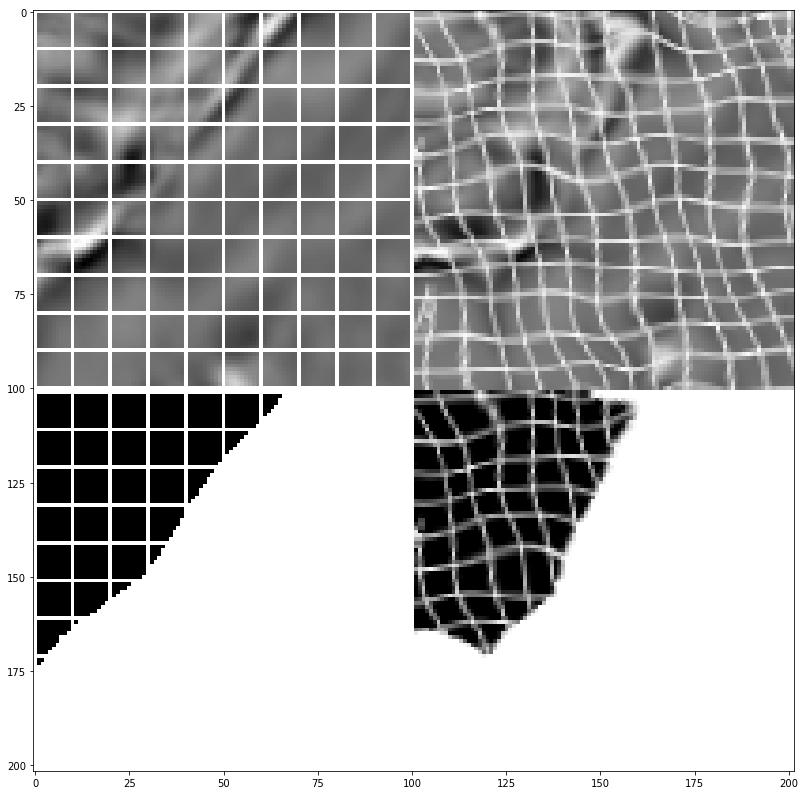

In [78]:
%matplotlib inline

# Apply transformation on image
im_merge_t = elastic_transform(im_merge, im_merge.shape[1], im_merge.shape[1] * 0.07, im_merge.shape[1] * 0.08)

# Split image and mask
im_t = im_merge_t[...,0]
im_mask_t = im_merge_t[...,1]

# Display result
plt.figure(figsize = (16,14))
plt.imshow(np.c_[np.r_[im, im_mask], np.r_[im_t, im_mask_t]], cmap='gray')